## Inference using MC dropout and CAM wrappers

This example shows how to use the Monte Carlo dropout and Class Activation Maps wrappers for a trained model. We will use some test images of the ICM-20.1 dataset presented in the thesis.

In [1]:
import tqdm as notebook_tqdm
# Clone the repository and install the requirementes file
!git clone "https://github.com/davidserra9/UncertaintyProxy.git"

# GPU
import torch
print("\nAvailable GPU: ")
torch.cuda.get_device_name(torch.cuda.current_device())

Cloning into 'UncertaintyProxy'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 194 (delta 111), reused 139 (delta 59), pack-reused 0
Receiving objects: 100% (194/194), 14.50 MiB | 9.98 MiB/s, done.
Resolving deltas: 100% (111/111), done.

Available GPU: 


/home/david/miniconda3/envs/TFM/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3060'

Load the model

In [2]:
# Load the trained model
from UncertaintyProxy.utils.NN_utils import *

MODEL = "efficientnet_b0"
DEVICE = "cuda"
SPECIES = ["Spatangus purpureus",
           "Echinaster sepositus",
           "Cerianthus membranaceus",
           "Bonellia viridis",
           "Scyliorhinus canicula",
           "Ophiura ophiura",
           "Background"]

model = initialize_model(model_name=MODEL,
                         num_classes=len(SPECIES),
                         load_model=True,
                         model_root=".")
model = model.eval()
model = model.to(DEVICE)

Model loaded from ./efficientnet_b0.pth.tar
+-----------------+-------+----------+----------+
|  architecture   | epoch | accuracy | f1 score |
+-----------------+-------+----------+----------+
| efficientnet_b0 |  16   |  0.837   |  0.827   |
+-----------------+-------+----------+----------+


Create both model wrappers

In [3]:
from UncertaintyProxy.utils.MCdropout_wrapper import MCDP_model
from UncertaintyProxy.utils.CAM_wrapper import AM_initializer

# Create the Uncertainty and CAM wrappers
mc_wrapper = MCDP_model(model=model,
                        num_classes=len(SPECIES),
                        device=DEVICE,
                        mc_samples=50)

cam_wrapper = AM_initializer(model= model,
                             technique="CAM")

Create a simple function to plot the image with the estimated uncertainty and the Class Activation Map

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from UncertaintyProxy.utils.uncertainty_metrics import predictive_entropy

def show_results(img_path, mc_wrapper, cam_wrapper, device):
    """ Function to run inference in 1 annotation (5 images) using the MC dropout and CAM wrappers.
    
        Parameters
        ----------
        img_path: str
        mc_wrapper: object
        cam_wrapper: object
        device: str
    """
    
    transformations = get_validation_augmentations() # image normalization
    
    # Read and transform image to tensor
    image_copy = cv2.imread(img_path)
    image = cv2.imread(img_path)[:, :, ::-1]
    tensor = transformations(image=image)['image']
    tensor = tensor.unsqueeze(0)
        
    # Estimate uncertainty with model wrapper and predictive entropy
    outputs = mc_wrapper(tensor.unsqueeze(0).to(device))
    mean = np.mean(outputs, axis=1)
    y_pred = np.argmax(mean)
    ent = predictive_entropy(mean)[0]
    img_copy = cv2.putText(image_copy, f"Uncertainty: {ent:.2f}", (20, 130), cv2.FONT_HERSHEY_SIMPLEX, 5, (255, 255, 255), 8)

    # Obtain class activation map and create a heat map
    cam, idx = cam_wrapper(tensor.to(device), idx=y_pred)
    heatmap = cv2.applyColorMap(
        cv2.resize((cam.detach().cpu().squeeze().numpy() * 255).astype(np.uint8), (image.shape[1], image.shape[0])),
        cv2.COLORMAP_JET)[:, :, ::-1]
    result = heatmap * 0.4 + image * 0.9
    map = result / np.max(result)

        # Append images stacked with the CAM heatmap
    inf_img = np.hstack([img_copy[:, :, ::-1], map * 255])
       
    # Plot Figure
    plt.figure(figsize=(12, 8))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Prediction: {SPECIES[y_pred]}", fontdict={'fontsize':15})
    plt.imshow(inf_img/255)

Pick the images and run inference

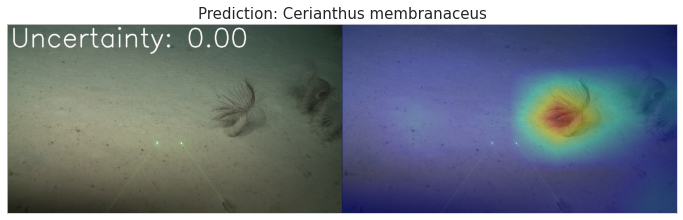

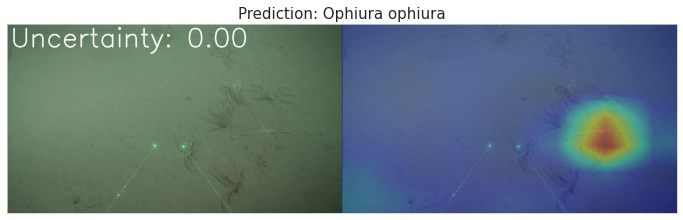

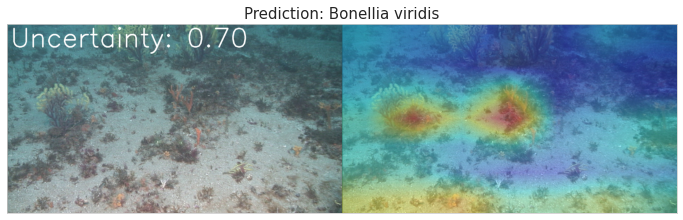

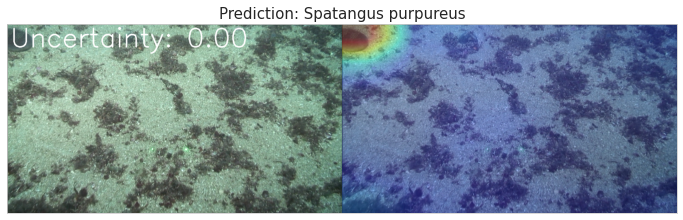

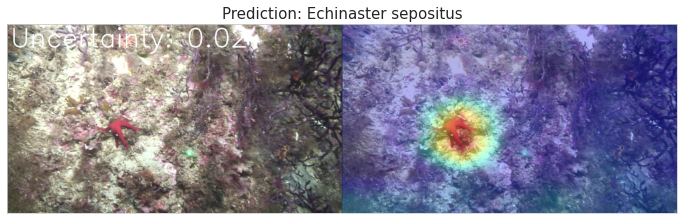

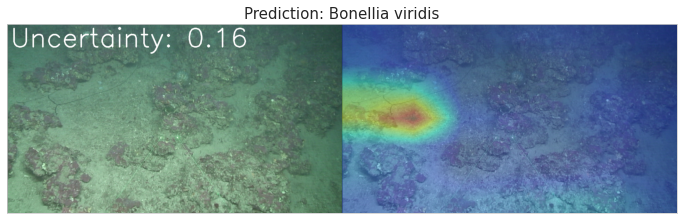

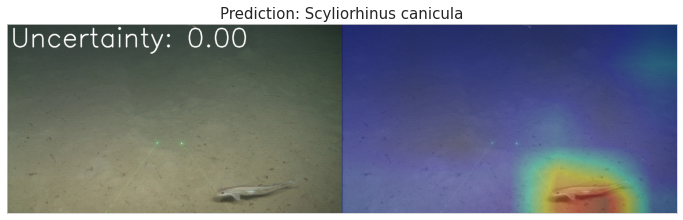

In [5]:
from glob import glob
# Obtain some images of the test set to run inference on

img_list = glob("test_images/*")
for img_path in img_list:
    show_results(img_path, mc_wrapper, cam_wrapper, DEVICE)